# MNEflow basic example

# Importing data

## 1. from MNE epochs

#### If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [1]:
#get to epochs using your mne-python pipeline
import os
from time import time

import mne
from mne.datasets import multimodal
import mneflow

mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
epochs_list = [mne.Epochs(raw, **c) for c in cond]

#here we concatenate epochs because each input file contains just one condition
#otherwise mneflow.produce_tfrecords can handle a list of epochs objects
epochs = mne.concatenate_epochs(epochs_list)

In [2]:
#Specify import options
import_opt = dict(savepath='../tfr/', #path where TFR files will be saved
           out_name='mne_sample_epochs', #name of TFRecords files
           input_type='epochs', #can also be "array"
           picks={'meg':'grad'}, #dict if input_type is mne.epochs.Epochs or path to saved '*-epo.fif'
           scale=True, #apply baseline_scaling
           crop_baseline=True, #remove baseline interval after scaling
           decimate = 2,
           scale_interval=(0,60), #indices in time axis corresponding to baseline interval
           savebatch=1, # number of input files per TFRecord file           
           save_origs=False, # whether to produce separate TFR-file for inputs in original order
           overwrite=True, #load existing meta.pkl file if it already exists
           val_size=0.1) #validations set size set to 10% of all data


   
if not os.path.exists(import_opt['savepath']):
    os.mkdir(import_opt['savepath'])
        
if os.path.exists(import_opt['savepath']+'meta.pkl'):
    meta = mneflow.load_meta(import_opt['savepath'])
else:
    meta = mneflow.produce_tfrecords(epochs,**import_opt)   

# 2. Other data import options

### 2.1 Saved mne.epochs (*-epo.fif) files
Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files

e.g. this will work

```python
epochs.save('test_saved_epochs.fif')
meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)
```
### 2.2. Arrays in *.mat or *.npz format
if the first argument is str mneflow.produce_tfrecords can also accept *.mat or *.npz format

e.g.

```python
data_path = '/m/nbe/scratch/braindata/izbrv/detection_data/'
filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
meta = mneflow.produce_tfrecords(filenames,**opt)
```
In this case, specify iput_type='array', and also provide array_keys keyword argument

e.g. 

```python
array_keys={'X':'my_data_samples','y':'my_labels'}
```

# 3.1. Choose from already implemented models

In [3]:
#specify optimizer parmeters
optimizer_params = dict(l1_lambda=3e-6,
              learn_rate=3e-4,
              dropout = .5,
              patience = 5,# patientce for early stopping
              min_delta = 5e-6,
              test_upd_batch = 20,#pseudo-real time test batch size
              n_iter = 10000, #total training iterations
              eval_step = 100, #evaluate validation loss each 10 epochs
              n_batch = 200,
              model_path = import_opt['savepath'] # path for saving the trained model
              ) 

#specify parameters specific for the model
#these are specific to LF-CNN]

lf_params = dict(n_ls=64, #number of latent factors
              filter_length=17, #convolutional filter length in time samples
              pooling = 5, #pooling factor
              stride = 5, #stride parameter for pooling layer
              )

#specify the path for saving the trained model
#here we will use the same folder as for the TFRecords
model_path = import_opt['savepath'] 

#initialize the model
model = mneflow.models.LFCNN(meta,optimizer_params,lf_params)

#this will initialize the iterators over the dataset,the computational graph and the optimizer
model.build()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Colocations handled automatically by placer.
lf-conv _init
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
fc _init
Initialization complete!


In [4]:
#train the model
start = time()
model.train()
stop = time() - start
print('Trained in {:.2f}s'.format(stop))

iter 0, train_loss 2.17321, train acc 0.135 val loss 2.24901, val acc 0.138298
iter 100, train_loss 1.43091, train acc 0.575 val loss 1.69872, val acc 0.244681
iter 200, train_loss 0.750413, train acc 0.845 val loss 1.18367, val acc 0.521277
iter 300, train_loss 0.37341, train acc 0.955 val loss 0.84541, val acc 0.712766
iter 400, train_loss 0.211506, train acc 0.98 val loss 0.687877, val acc 0.776596
iter 500, train_loss 0.118625, train acc 0.99 val loss 0.585177, val acc 0.808511
iter 600, train_loss 0.0785658, train acc 0.995 val loss 0.539921, val acc 0.819149
* Patience count 1
iter 700, train_loss 0.0534798, train acc 0.995 val loss 0.551865, val acc 0.819149
iter 800, train_loss 0.0366814, train acc 1 val loss 0.525157, val acc 0.808511
iter 900, train_loss 0.025682, train acc 1 val loss 0.494636, val acc 0.851064
iter 1000, train_loss 0.0175484, train acc 1 val loss 0.47818, val acc 0.840426
* Patience count 2
iter 1100, train_loss 0.0151925, train acc 1 val loss 0.494946, val 

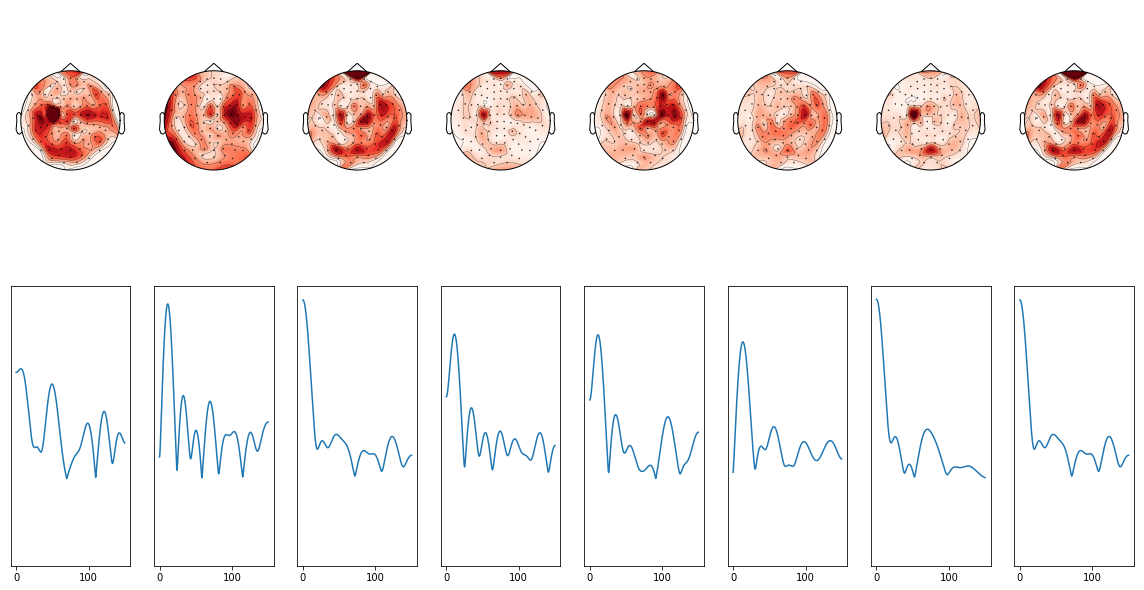

/u/62/zubarei1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [8]:
model.compute_patterns(output='patterns')
#explore output layer weights
#TODO: Fix bug related to varying sampling rates and pooling factors
#f = model.plot_out_weihts()

#explore informative spatial patterns(LF-CNN only)
model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', spectra=True, scale=True)

# 3.2. Or specify your own neural network

In [9]:
#let's make a simple peceptron-like classifier using all channels*timepoints as features with keras
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.constraints import max_norm

class MyNetwork(mneflow.models.Model):
    #In the simplest case all you need to do is to override the computational graph with your own
    def _build_graph(self):
        self.h_params['architecture'] = 'my_own'
        input_main   = self.X
        flatten      = Flatten()(input_main)
        dense        = Dense(self.h_params['n_classes'], kernel_constraint = max_norm(0.5))(flatten)
        y_pred      = Activation('softmax')(dense)
        #         This method should return the following handles
        return y_pred
    
#    the same can be done with _set_optimizer method if you need to use a custom optimization pipeline
#    def _set_optimizer(self):
#         Inputs:
#         -------
#         self.y_pred : 
#                        predictions, outputs of the computational graph
#         self.y_ :
#                        target_variable, output of dataset.iterator
#
#         Specify cost/objective function
#         p_classes = tf.nn.softmax(self.y_pred)
#         loss = custom_loss_function(labels=self.y_, logits=self.y_pred))
        
#         Specify optimizer, and performance metric, e.g.
#         
#         train_step = tf.train.AdamOptimizer(self.params['learn_rate']).minimize(loss)
#         correct_prediction = tf.equal(tf.argmax(self.y_pred, 1), self.y_)
#         performance_metric = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')
#         
#         This method should return the following handles
#         return train_step, performance_metric, loss, p_classes

optimizer_params = dict(l1_lambda=3e-6,
              learn_rate=3e-4,
              dropout = .5,
              patience = 5,# patientce for early stopping
              min_delta = 5e-3, #note the increased convergence threshold
              n_iter = 10000, #maximum training epochs
              eval_step = 100, #evaluate validation loss each 10 epochs
              n_batch = 200,
              model_path = import_opt['savepath']) # path for saving the trained model) #training batch size) 

    
m2 = MyNetwork(meta,optimizer_params)
# Don't forget to call build()
m2.build()
start = time()
m2.train()
stop = time() - start
print('Trained in {:.2f}s'.format(stop))

Initialization complete!
iter 0, train_loss 2.07935, train acc 0.1 val loss 2.06519, val acc 0.170213
iter 100, train_loss 1.27737, train acc 1 val loss 1.5752, val acc 0.723404
iter 200, train_loss 1.27588, train acc 1 val loss 1.55625, val acc 0.744681
* Patience count 1
iter 300, train_loss 1.27537, train acc 1 val loss 1.58407, val acc 0.734043
* Patience count 2
iter 400, train_loss 1.27465, train acc 1 val loss 1.56158, val acc 0.765957
iter 500, train_loss 1.27426, train acc 1 val loss 1.54876, val acc 0.765957
iter 600, train_loss 1.27416, train acc 1 val loss 1.5419, val acc 0.765957
iter 700, train_loss 1.27413, train acc 1 val loss 1.53669, val acc 0.765957
* Patience count 3
iter 800, train_loss 1.27411, train acc 1 val loss 1.53257, val acc 0.776596
iter 900, train_loss 1.2741, train acc 1 val loss 1.52916, val acc 0.776596
* Patience count 4
iter 1000, train_loss 1.27409, train acc 1 val loss 1.52627, val acc 0.787234
iter 1100, train_loss 1.27408, train acc 1 val loss 1.

#TODO: across-subject/leave-one-subject-out example